# LIGO - Gravitational Waves Detectability

## Part 1 : Reproduce Paper Results

In [1]:
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks")
from Utilities import plot_settings
from LIGO_Utils.LigoUtils import plot_training_history

In [14]:
def plot_results(history, title=''):
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy', linewidth=2)
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\NN_results"+f"\{title}"+".png")
    plt.show()

Loading downsampled data with unbalanced classes

In [2]:
y = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\Npy\y_ds_100k.npy")
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\Npy\data_ds_100k.npy")
keys = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\Npy\keys.npy")

In [3]:
print(f'Detectable signals : {len(y[y==1])/len(y) * 100 :.3}%')

Detectable signals : 14.7%


We are looking for pretty rare signals, but not that rare actually...But first of all we have to rescale data and separate btw train and test set

In [4]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

In [5]:
S = RobustScaler().fit_transform(data)

In [6]:
S_train, S_test, y_train, y_test = train_test_split(S, y, test_size=0.2, shuffle=True, random_state=137)

Text(0.5, 1.0, 'Robust scaling')

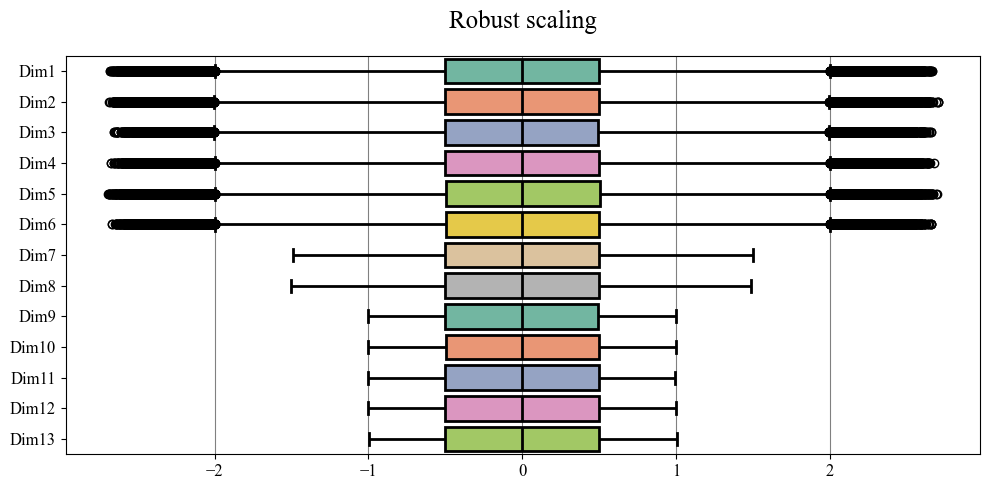

In [7]:
df = pd.DataFrame(S, columns=[f'Dim{i}' for i in range(1, 14)])

# Plot distributions
sns.boxplot(data=df, orient="h", palette="Set2", linecolor='k', linewidth=2)
plt.title("Robust scaling")

Define the model described in the paper "https://arxiv.org/pdf/2007.06585":
 - $1^{st}$ layer : 13 neurons
 - $2^{nd}$ layer : 32 neurons
 - $3^{rd}$ layer : output

ReLU activation function in inner layers and sigmoid activation function for outer layer.
Define the model

In [8]:
import keras.backend as k

In [32]:
k.clear_session()

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam

model = Sequential([
    Input(shape=(13,)),
    Dense(32, activation='relu', kernel_initializer='glorot_uniform'),
    Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
])

# Adam optimizer with learning rate 0.01
adam = Adam(learning_rate=0.01)

model.compile(optimizer=adam,  loss='binary_crossentropy',  metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model
history = model.fit(
    S_train,         # input features
    y_train,         # target labels
    epochs=150,      # number of passes over the data
    batch_size=32,   # number of samples per gradient update
    validation_data = (S_test, y_test),  
    verbose=1
)

Epoch 1/150
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9254 - loss: 0.1633 - val_accuracy: 0.9563 - val_loss: 0.0983
Epoch 2/150
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9596 - loss: 0.0926 - val_accuracy: 0.9619 - val_loss: 0.0869
Epoch 3/150
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9614 - loss: 0.0868 - val_accuracy: 0.9631 - val_loss: 0.0835
Epoch 4/150
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9607 - loss: 0.0896 - val_accuracy: 0.9613 - val_loss: 0.0871
Epoch 5/150
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9643 - loss: 0.0819 - val_accuracy: 0.9647 - val_loss: 0.0820
Epoch 6/150
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9663 - loss: 0.0771 - val_accuracy: 0.9682 - val_loss: 0.0734
Epoch 7/150
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9667 - loss: 0.0771 - val_accuracy: 0.9712 - val_loss: 0.0675
Epoch 8/150
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9701 - loss:

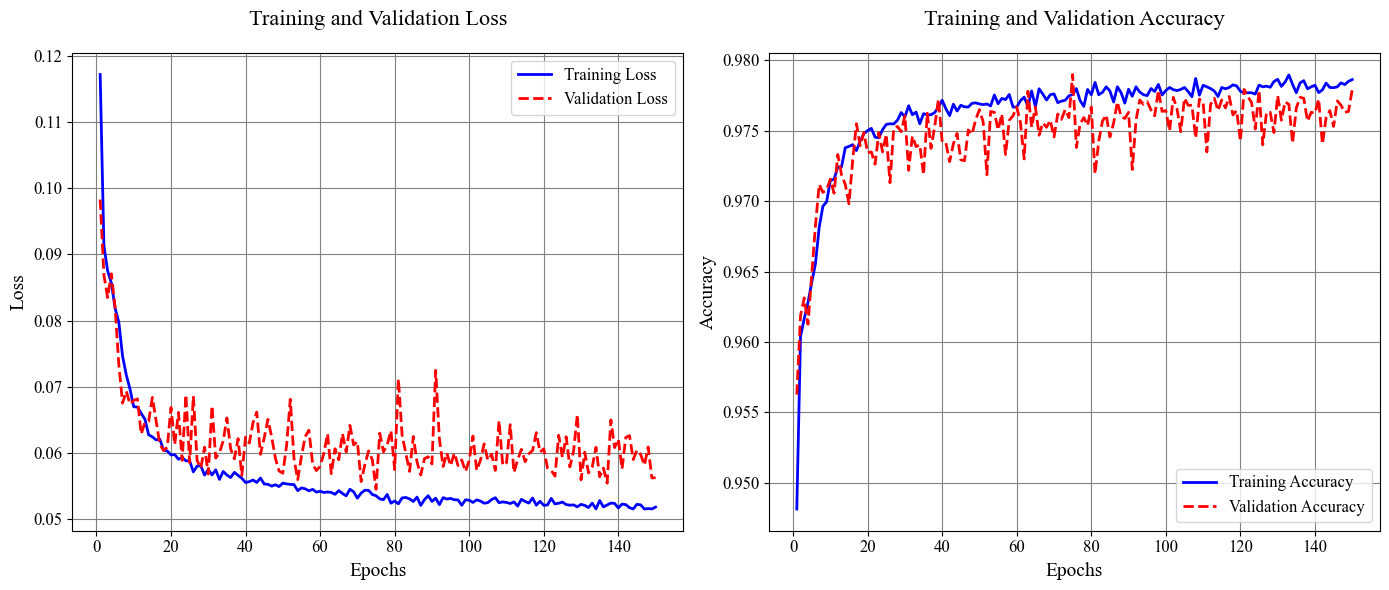

In [17]:
plot_results(history, 'model1')

Good news!
- No signs of overfitting: training and validation metrics are tightly aligned.
- Well-tuned model: good balance of capacity and regularization.
- High performance: excellent accuracy and low loss on both sets.

In [16]:
with open(r'C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\NN_results\model1_training_history.json', 'w') as f:
    json.dump(history.history, f)

Let's try something else:
1. Changing learning rate if model does not learn for 5 epochs + keep track for visualization
2. Early stop if model does not learn anything for 10 epochs

In [39]:
import tensorflow as tf

class LRTLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.lrs.append(lr)

In [34]:
model = Sequential([
    Input(shape=(13,)),

    Dense(64, activation='relu', kernel_initializer='glorot_uniform'),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_initializer='glorot_uniform'),
    Dropout(0.2),

    Dense(16, activation='relu', kernel_initializer='glorot_uniform'),

    Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
])


optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,565 (41.27 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,044 (27.52 KB)

In [41]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)
lr_tracker = LRTLogger()

In [42]:
history2 = model.fit(
    S_train, y_train,
    validation_data=(S_test, y_test),
    epochs=150,
    callbacks=[early_stop, reduce_lr, lr_tracker],
    verbose=1
)

Epoch 1/150


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9520 - loss: 0.1096 - val_accuracy: 0.9582 - val_loss: 0.0957 - learning_rate: 0.0100
Epoch 2/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9575 - loss: 0.1023 - val_accuracy: 0.9610 - val_loss: 0.0868 - learning_rate: 0.0100
Epoch 3/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9583 - loss: 0.0956 - val_accuracy: 0.9622 - val_loss: 0.0847 - learning_rate: 0.0100
Epoch 4/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9585 - loss: 0.0954 - val_accuracy: 0.9635 - val_loss: 0.0819 - learning_rate: 0.0100
Epoch 5/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9597 - loss: 0.0941 - val_accuracy: 0.9618 - val_loss: 0.0822 - learning_rate: 0.0100
Epoch 6/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9594 - loss: 0.0910 - val_accuracy: 0.9656 - val_loss: 0.0773 - learning_rate: 0.0100
Epoch 7/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9604 - los

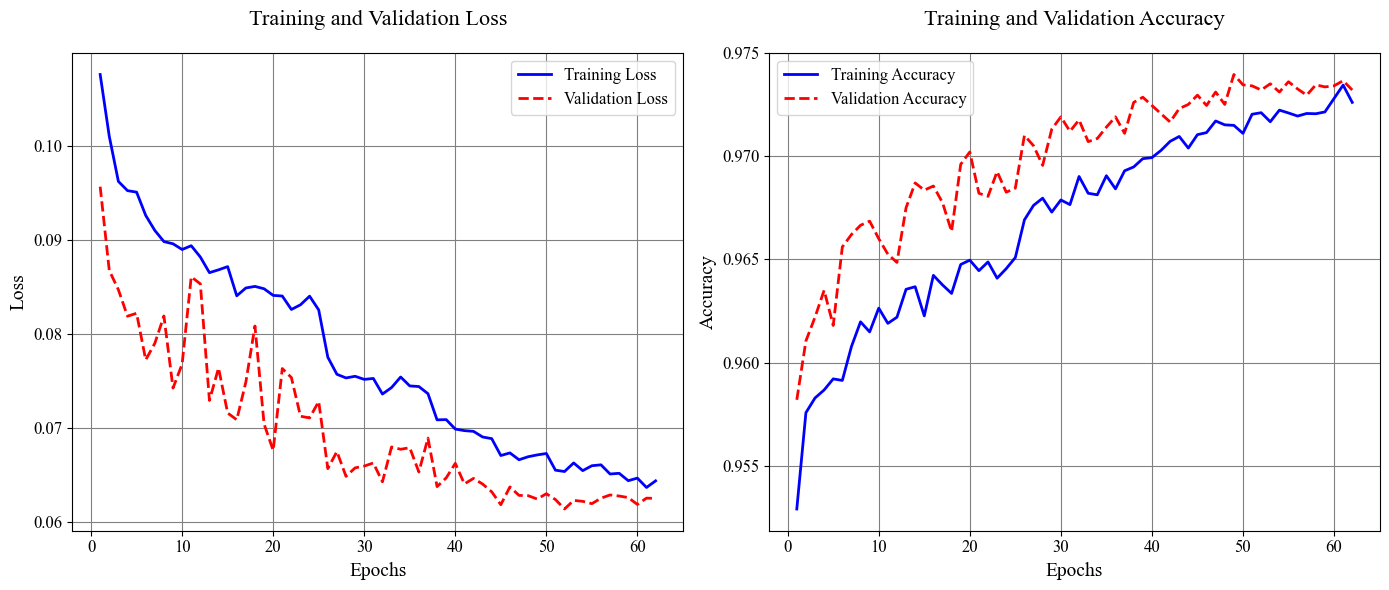

In [43]:
plot_results(history2, 'model2')

In [44]:
with open(r'C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\NN_results\model2_training_history.json', 'w') as f:
    json.dump(history2.history, f)

New model: Dense layers + Batch normalization, LASSO regularization

In [45]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l1
from keras.optimizers import Adam

In [47]:
k.clear_session()

In [48]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(13,)))

    # Hidden layer 1
    model.add(Dense(
        units=hp.Int('units1', min_value=32, max_value=128, step=16),
        activation='relu',
        kernel_initializer='glorot_uniform',
        kernel_regularizer=l1(hp.Float('l1_reg', 1e-5, 1e-2, sampling='log'))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

    # Hidden layer 2
    model.add(Dense(
        units=hp.Int('units2', min_value=16, max_value=64, step=16),
        activation='relu',
        kernel_initializer='glorot_uniform',
        kernel_regularizer=l1(hp.Float('l1_reg2', 1e-5, 1e-2, sampling='log'))
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))

    # Output
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer with tunable learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

RandomSearch to speed up **hyperparameter tuning**

In [49]:
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=1,
    directory='keras_tuner_dir',
    project_name='lasso_bn_model'
)

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)

tuner.search(
    S_train, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

# Get the best model
best_model = tuner.get_best_models(1)[0]

Trial 2 Complete [00h 10m 06s]
val_accuracy: 0.9682499766349792

Best val_accuracy So Far: 0.9682499766349792
Total elapsed time: 00h 20m 25s


c:\Users\ricca\Documents\Unimib-Code\AstroStatistics\tf-venv\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**Fit and plot**

In [50]:
history3 = best_model.fit(
    S_train, y_train,
    validation_data = (S_test, y_test),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, lr_tracker]
)

Epoch 1/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9523 - loss: 0.1326 - val_accuracy: 0.9573 - val_loss: 0.1155 - learning_rate: 0.0052
Epoch 2/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9522 - loss: 0.1342 - val_accuracy: 0.9605 - val_loss: 0.1145 - learning_rate: 0.0052
Epoch 3/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9504 - loss: 0.1379 - val_accuracy: 0.9617 - val_loss: 0.1130 - learning_rate: 0.0052
Epoch 4/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9529 - loss: 0.1356 - val_accuracy: 0.9627 - val_loss: 0.1131 - learning_rate: 0.0052
Epoch 5/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9537 - loss: 0.1347 - val_accuracy: 0.9590 - val_loss: 0.1157 - learning_rate: 0.0052
Epoch 6/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9520 - loss: 0.1357 - val_accuracy: 0.9562 - val_loss: 0.1208 - learning_rate: 0.0052
Epoch 7/150
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accura

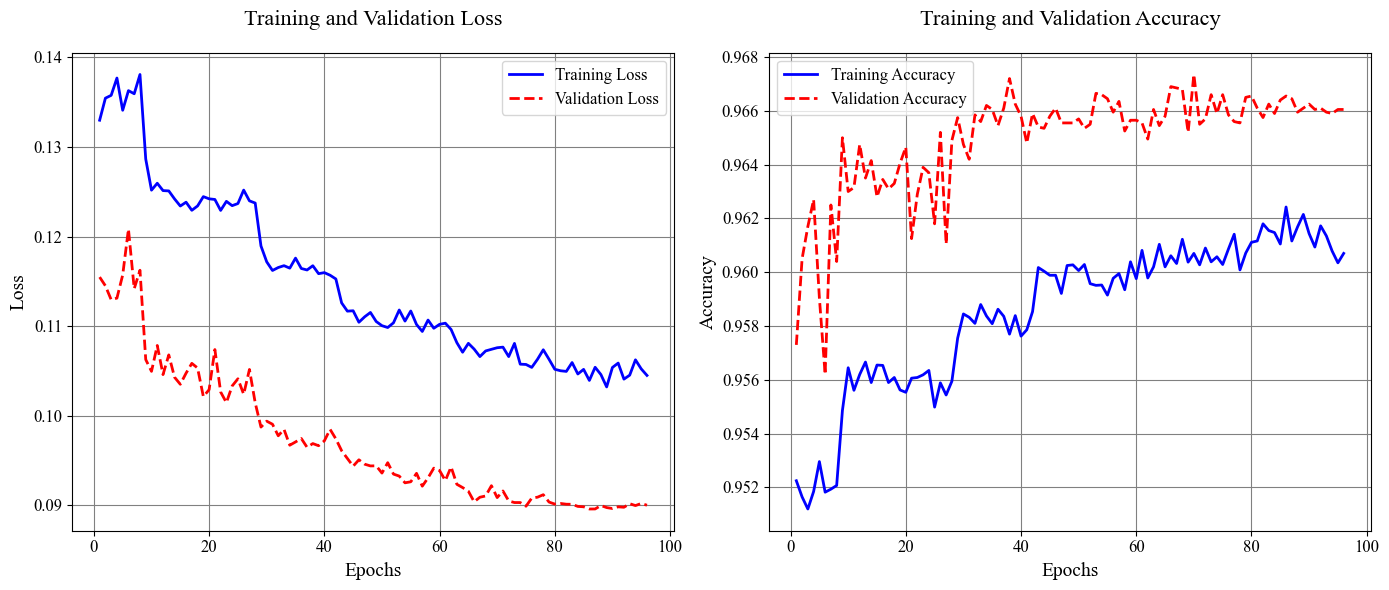

In [51]:
plot_results(history3)

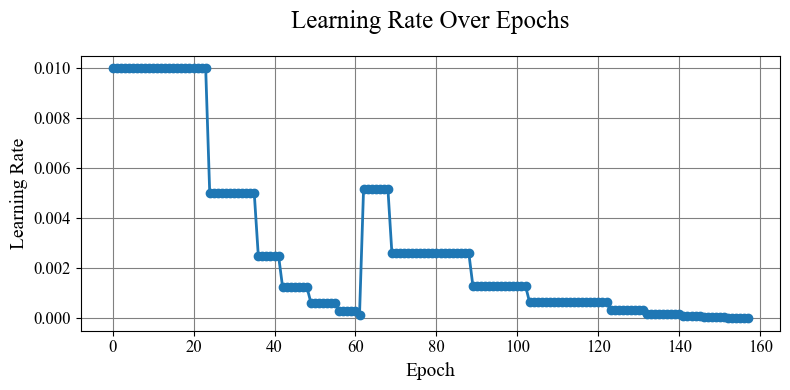

In [52]:
plt.figure(figsize=(8, 4))
plt.plot(lr_tracker.lrs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.savefig('lr_model3')

In [54]:
with open(r'C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\NN_results\model3_training_history.json', 'w') as f:
    json.dump(history3.history, f)